In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation

/content/drive/MyDrive/Colab Notebooks/Test_segmentation


In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import matplotlib.pyplot as plt

In [ ]:
img = img_to_array(img)

# Test with small data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import skimage
import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import math

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils
import helpers

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils


In [ ]:
rgb_dir='/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb'
seg_dir='/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg'

images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

In [ ]:
import random
val_samples = 70
images=[]
annotations=[]
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')
for i in range(97):
    img1,label_img= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])#[:,:,2]
    img1=cv2.resize(img1,(256,256))
    label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
    # label_img = img_to_array(label_img)
    mask1 = np.float32(helpers.one_hot_it(label_img,label_values))
    mask1 = helpers.reverse_one_hot(mask1)
   
    # mask1 = helpers.colour_code_segmentation(mask1,label_values)
    mask1 = mask1.astype('float32')
    mask1 = cv2.resize(mask1,(256,256,))
    images.append(img1)
    annotations.append(mask1)
images=np.array(images)
annotations=np.array(annotations)

In [3]:
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)
# classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')

In [ ]:
# test_ano = annotations
# test_ano = np.array(test_ano)
# plt.subplot(1,2,1)
# plt.imshow(np.expand_dims(annotations[4], axis=0))
# plt.subplot(1,2,2)
# plt.imshow(test_ano[4])

In [ ]:
test_ano.reshape(512,1024,97)
test_ano.shape

(97, 512, 1024)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


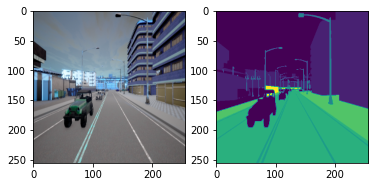

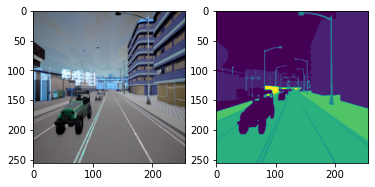

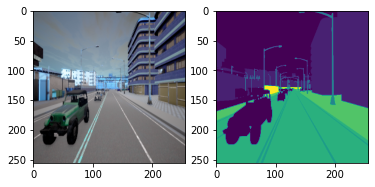

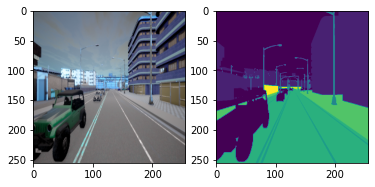

In [ ]:
for i in range(1,5):
    plotter(images[i],annotations[i])
print(annotations[1])

In [ ]:
random.Random(97).shuffle(images)
random.Random(97).shuffle(annotations)
train_data=images[:-val_samples]
train_annotate=annotations[:-val_samples]
valid_data=images[-val_samples:]
valid_annotate=annotations[-val_samples:]

In [ ]:
valid_data.shape, valid_annotate.shape

((70, 256, 256, 3), (70, 256, 256))

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
      inputs = keras.Input(shape=img_size + (3,))

      ### [First half of the network: downsampling inputs] ###

      # Entry block
      x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
      x = layers.BatchNormalization()(x)
      x = layers.Activation("relu")(x)

      previous_block_activation = x  # Set aside residual

      # Blocks 1, 2, 3 are identical apart from the feature depth.
      for filters in [64, 128, 256]:
          x = layers.Activation("relu")(x)
          x = layers.SeparableConv2D(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.Activation("relu")(x)
          x = layers.SeparableConv2D(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

          # Project residual
          residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
              previous_block_activation
          )
          x = layers.add([x, residual])  # Add back residual
          previous_block_activation = x  # Set aside next residual

      ### [Second half of the network: upsampling inputs] ###

      for filters in [256, 128, 64, 32]:
          x = layers.Activation("relu")(x)
          x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.Activation("relu")(x)
          x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.UpSampling2D(2)(x)

          # Project residual
          residual = layers.UpSampling2D(2)(previous_block_activation)
          residual = layers.Conv2D(filters, 1, padding="same")(residual)
          x = layers.add([x, residual])  # Add back residual
          previous_block_activation = x  # Set aside next residual

      # Add a per-pixel classification layer
      outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

      # Define the model
      model = keras.Model(inputs, outputs)
      return model

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * math.exp(-0.1)
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
keras.backend.clear_session()
model = get_model((256,256), 13)


model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("test_prof_data.h5", save_best_only=True),
    keras.callbacks.LearningRateScheduler(scheduler),
]

# define data preparation
# shift = 0.2
# model = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift,rotation_range=180)
# # epochs = 10

In [ ]:
history=model.fit(images,annotations,batch_size=64, epochs = 50 ,callbacks=callbacks,validation_split=0.2)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test model and calculate mean IoU

In [4]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/test_prof_data_latest.h5')

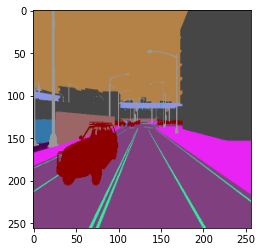

In [35]:
path_test_iou = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb/30.jpg'
path_label_img_iou = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg/30.png'
label_img_iou = cv2.imread(path_label_img_iou)
img_test_iou = cv2.imread(path_test_iou)
img_test_iou = cv2.resize(img_test_iou,(256,256,))
label_img_iou = cv2.resize(label_img_iou,(256,256,))
plt.imshow(label_img_iou)

In [71]:
label_img_iou = cv2.cvtColor(label_img_iou,cv2.COLOR_BGR2RGB)
# label_img = img_to_array(label_img)
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')
mask_iou = helpers.one_hot_it(label_img_iou,label_values)
mask_iou = helpers.reverse_one_hot(mask_iou)
# mask_iou = helpers.mask2onehot(mask_iou,13)

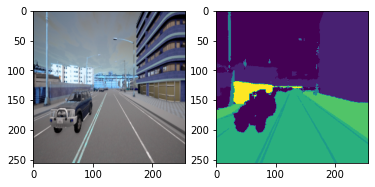

In [38]:
getshape=img_test_iou.shape
pred = model.predict(img_test_iou.reshape(1,getshape[0],getshape[1],getshape[2]))

#print(pred.shape)        
newimg = np.zeros((256,256))
#print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.4:
                newimg[j,k] = i
# newimg = helpers.colour_code_segmentation(newimg,label_values)
plotter(img_test_iou,newimg)
# plotter(test,annotations[number])

In [80]:
import sys
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils/unet_segmentation_metrics/umetrics
# sys.path.append('..')
import core

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils/unet_segmentation_metrics/umetrics


 Segmentation Metrics (n=1)
Strict: True (IoU > 0.5)
n_true_labels: 84
n_pred_labels: 22
n_true_positives: 1
n_false_positives: 12
n_false_negatives: 36
IoU: 0.583
Jaccard: 0.020
pixel_identity: 0.939
localization_error: 0.252



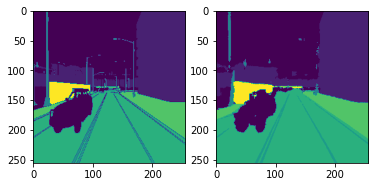

In [85]:
metrics = core.calculate(mask_iou,newimg,strict=True, iou_threshold=0.5)
print(metrics.results)
plotter(mask_iou,newimg)

In [13]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data
import seg_metrics

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data


In [ ]:
seg_metrics.mean_dice(mask,pred)#,'iou',mean_per_class=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5709414>

# Continue to train

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data
!unzip model_tf.zip

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data
Archive:  model_tf.zip
   creating: model_tf/assets/
  inflating: model_tf/variables/variables.index  
  inflating: model_tf/saved_model.pb  
  inflating: model_tf/variables/variables.data-00000-of-00001  


In [ ]:
# loading the saved model
loaded_model = keras.models.load_model('./model_tf')

In [ ]:
# retraining the model
loaded_model.fit(images, annotations, epochs = 10, validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 12s 3s/step - loss: 1.2972 - accuracy: 0.7899 - val_loss: 6.2594 - val_accuracy: 0.3923
Epoch 2/10
3/3 [==============================] - 1s 449ms/step - loss: 0.8237 - accuracy: 0.8000 - val_loss: 8.2365 - val_accuracy: 0.3923
Epoch 3/10
3/3 [==============================] - 1s 450ms/step - loss: 0.5597 - accuracy: 0.8617 - val_loss: 7.6539 - val_accuracy: 0.3923
Epoch 4/10
3/3 [==============================] - 1s 450ms/step - loss: 0.4705 - accuracy: 0.8698 - val_loss: 6.3535 - val_accuracy: 0.3886
Epoch 5/10
3/3 [==============================] - 1s 446ms/step - loss: 0.3993 - accuracy: 0.8774 - val_loss: 6.1136 - val_accuracy: 0.3854
Epoch 6/10
3/3 [==============================] - 1s 445ms/step - loss: 0.3575 - accuracy: 0.8847 - val_loss: 6.3106 - val_accuracy: 0.2942
Epoch 7/10
3/3 [==============================] - 1s 447ms/step - loss: 0.3379 - accuracy: 0.8929 - val_loss: 6.2749 - val_accuracy: 0.3352
Epoch 8/10
3/3 [======

# Test one hot encoding

In [48]:
path_label_img = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg/03.png'
path_img = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb/03.jpg'
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')

In [ ]:
print(len(label_values))

13


In [ ]:
img1,label_img= cv2.imread(path_img),cv2.imread(path_label_img)
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)

[[2.25 9.   9.   ... 0.   0.   0.  ]
 [0.   9.   9.   ... 0.   0.   0.  ]
 [0.   9.   9.   ... 0.   0.   0.  ]
 ...
 [7.   7.   7.   ... 7.   7.   7.  ]
 [7.   7.   7.   ... 7.   7.   7.  ]
 [7.   7.   7.   ... 7.   7.   7.  ]]


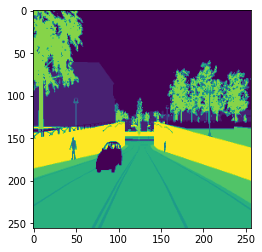

In [49]:
# label_img = img_to_array(label_img)
mask = helpers.one_hot_it(label_img,label_values)
mask = helpers.reverse_one_hot(mask)
# #mask = cv2.resize(mask,(256,256))
# mask = helpers.colour_code_segmentation(mask,label_values)
mask = mask.astype('float32')
mask = cv2.resize(mask,(256,256,))
# plt.imshow(mask)
# mask.shape
# mask = np.array(mask)
print(mask)
plt.imshow(mask)

In [ ]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return semantic_map
    
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

In [ ]:
from skimage.transform import resize

mask2 = helpers.reverse_one_hot(mask2)
mask2 = resize(mask2,(256,256,))
plt.imshow(mask2)
mask2.shape

(256, 256)

In [ ]:
semSegClasses = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0]     # TrafficSigns 
 } 

In [ ]:
def plot_img(img,label_img):
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(label_img)
    

In [ ]:
import random
val_samples = 70
images=[]
label_images=[]
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')
for i in range(97):
    img1,label_img= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])#[:,:,2]
    img1=cv2.resize(img1,(256,256))
    label_img = cv2.resize(label_img,(256,256))
    label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
    
    # label_img = img_to_array(label_img)
    mask1 = np.float32(helpers.one_hot_it(label_img,label_values))
    mask1 = helpers.reverse_one_hot(mask1)
   
    # # mask1 = helpers.colour_code_segmentation(mask1,label_values)
    # mask1 = mask1.astype('float32')
    # mask1 = cv2.resize(mask1,(256,256,))
    images.append(img1)
    label_images.append(mask1)
images=np.array(images)
label_images=np.array(label_images)

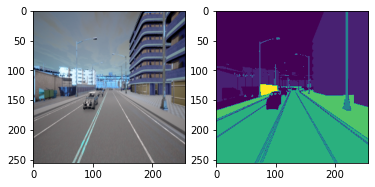

In [ ]:
plot_img(images[10],label_images[10])

In [ ]:
print('Number of unique colors:', len(np.unique(label_images[6])))

Number of unique colors: 7


In [ ]:
overWrite_img = img_test.copy()
freeSpace = newimg.copy()
for i in range(256):
  for j in range(256):
    if newimg[j,i] == 7:
      freeSpace[j,i] = 7 
      # print('successfully overlaped')
    else:
      freeSpace[j,i] = 0
      

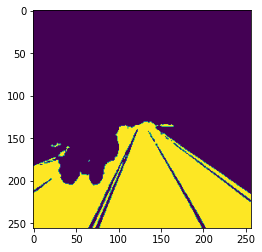

# TEST semantic segmentation with machine learning

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation
!git clone https://github.com/erees1/faces-segmentation

/content/drive/MyDrive/Colab Notebooks/Test_segmentation
Cloning into 'faces-segmentation'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 227 (delta 8), reused 17 (delta 3), pack-reused 199
Receiving objects: 100% (227/227), 65.53 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Checking out files: 100% (180/180), done.


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/faces-segmentation/src
# Import my functions
import image_processing as ip
import label_processing as lbp
import feature_processing as ftp
import utility_functions as util


/content/drive/MyDrive/Colab Notebooks/Test_segmentation/faces-segmentation/src


In [38]:
# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
import skimage.measure

from sklearn.pipeline import Pipeline


In [ ]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(images,
                                                    label_images,
                                                    shuffle=True,
                                                    random_state=0,
                                                    train_size=0.7)

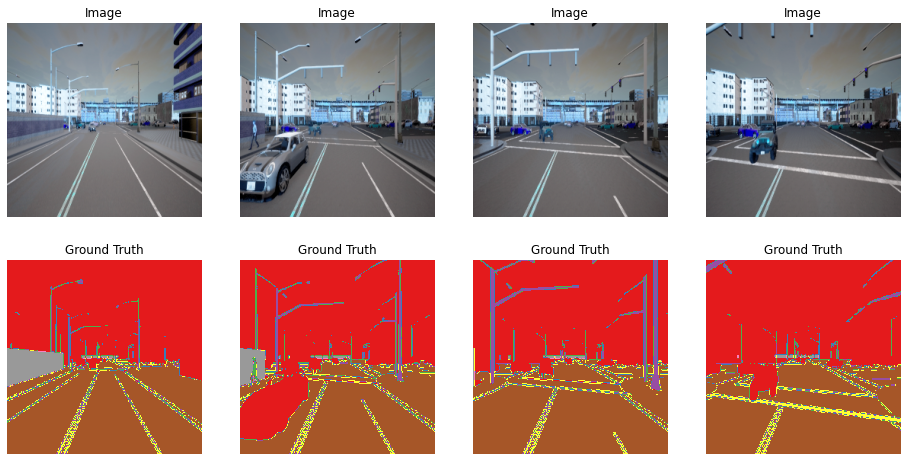

In [ ]:
# Inspect some of the images
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,8))
for i in range(4):
    axi = ax[:,i]
    util.view_data(img=X_train[i], gt=Y_train[i], axis=0, ax=axi)

In [ ]:
# Define feature parameters
feature_params = {'color': 'gray', 
                  'loc': True}

# Create preditor features
feat = ftp.CreateFeatures(feature_params)

# Model
rfc1 = RandomForestClassifier(n_estimators=10, verbose=0, n_jobs=-1)

# Setup pipe
steps = [('features', feat), ('model', rfc1)]
pipe = Pipeline(steps)


In [ ]:
pipe.fit(X_train, Y_train.ravel())

Pipeline(memory=None,
         steps=[('features',
                 CreateFeatures(color={'color': 'gray', 'loc': True}, hog=False,
                                loc=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False

In [ ]:
raw_label_mapping = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0]     # TrafficSigns 
 } 
 # Desired labels
desired_labels = [
    0,
    10,
    7,
]
for key,value in raw_label_mapping.items():
  print(value)

[0, 0, 0]
[70, 70, 70]
[190, 153, 153]
[72, 0, 90]
[220, 20, 60]
[153, 153, 153]
[157, 234, 50]
[128, 64, 128]
[244, 35, 232]
[107, 142, 35]
[0, 0, 255]
[102, 102, 156]
[220, 220, 0]


In [ ]:
def score_seg_model(model, X_test, y_test):
    '''
    Returns accurancy score and classification report for a given model.

    Parameters:
        model: model to be evaluated.
        X_test: test data.
        y_test: ground truths.
        
    '''
    
    # Set model.verbose to 0 to prevent clutered outputs
    model.verbose = 0
    
    print('Accuracy Score', model.score(X_test, y_test))
    
    y_test_predict = model.predict(X_test)
    
    # lb = [(key, mapping[key]) for key in mapping.keys()]
    # labels = [i[1] for i in lb]
    labels = [0,1,2,3,4,5,6, 7,8,9, 10]
    target_names = ['None','Buildings','Fences','Other','Pedestrians','Poles','RoadLines',
                    'Roads','Sidewalks','Vegetation','Vehicles']
    # target_names= [i[0] for i in lb]

    print(
        classification_report(y_test,
                              y_test_predict,
                              labels = labels,
                              target_names=target_names))

In [ ]:
# Score the model
score_seg_model(pipe, X_test, Y_test.ravel())

Accuracy Score 0.9626261393229166


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        None       0.96      0.96      0.96    748966
   Buildings       0.95      0.97      0.96    364844
      Fences       0.00      0.00      0.00         0
       Other       0.00      0.00      0.00         0
 Pedestrians       0.74      0.21      0.32       667
       Poles       0.84      0.59      0.69     44799
   RoadLines       0.93      0.90      0.91     23606
       Roads       0.98      0.99      0.98    621796
   Sidewalks       0.96      0.97      0.96    116960
  Vegetation       0.84      0.66      0.74        32
    Vehicles       0.00      0.00      0.00         0

   micro avg       0.96      0.96      0.96   1921670
   macro avg       0.65      0.57      0.59   1921670
weighted avg       0.96      0.96      0.96   1921670



In [ ]:
Y_pred = pipe.predict(X_test).reshape(Y_test.shape)

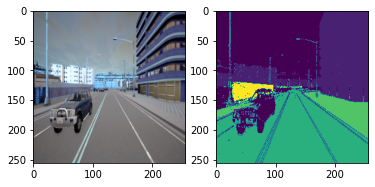

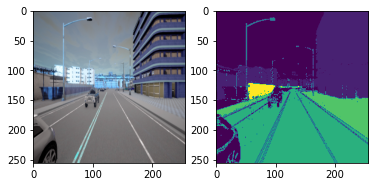

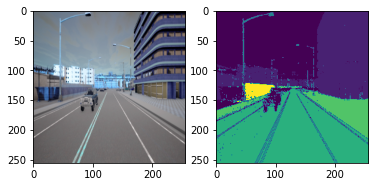

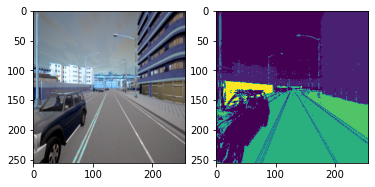

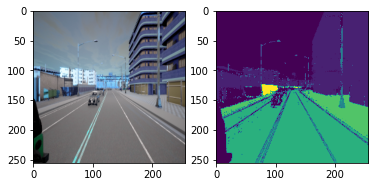

In [ ]:
# Inspect some of the predicted images
# fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,8))
for i in range(15,20):
    plotter(X_test[i],Y_pred[i])


In [ ]:
Y_pred.shape

(30, 256, 256)

In [ ]:
for i in range(30):
  for j in range(256):
    for z in range(256):
      if Y_pred[i,z,j] != 7 and Y_pred[i,z,j] != 10:
        Y_pred[i,z,j] = 0

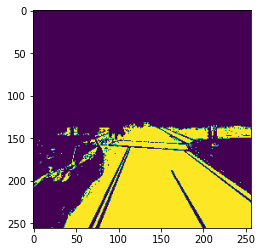

In [ ]:
plt.imshow(Y_pred[28])

# Test free space using segmentation result and ransac algorithm


This small example shows the relationship between the world coordinates $[x, y, z]$ and the projected image coordinates $[u, v]$ depending on the values in the camera matrix $A$.

$$u = f_x\frac{x}{z} + p_x$$

$$v = f_y\frac{-y}{z} + p_y$$

$$A = \begin{bmatrix} f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1 \end{bmatrix}$$

In [25]:
cam_mtx = np.array([
    [358.5, 0.0,   512.0],
    [0.0,   358.5, 256.0],
    [0.0,   0.0,   1.0],
    
])
# x = (u-px)*z/f
# y = (-v+py)*z/f
# z = depth

semSegClasses = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0]     # TrafficSigns 
 } 

In [4]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/test_prof_data_latest.h5')
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')

In [5]:
path_test = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/rgb_img.jpg'
depth_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/depth_img.png'
label_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/label_img.png'
img_test = cv2.imread(path_test)
label_img = cv2.imread(label_path)
img_test = cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB)
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
depth_img = cv2.imread(depth_path,-1)
depth_img = depth_img/100.0

In [9]:
depth_img.shape

(512, 1024)

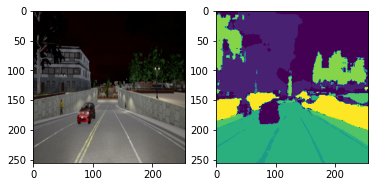

In [8]:
predicted_img = cv2.resize(img_test,(256,256))

getshape = predicted_img.shape
pred = model.predict(predicted_img.reshape(1,getshape[0],getshape[1],getshape[2]))

#print(pred.shape)        
predicted_mask = np.zeros((256,256))
#print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.4:
                predicted_mask[j,k] = i
# newimg = helpers.colour_code_segmentation(newimg,label_values)
plotter(predicted_img,predicted_mask)

In [16]:
predicted_mask.astype('float32')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.]], dtype=float32)

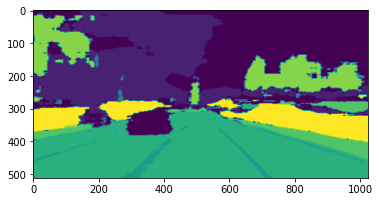

In [20]:
predicted_mask_resize = cv2.resize(predicted_mask,(1024,512,))
plt.imshow(predicted_mask_resize)

In [23]:
mask_gound = np.float32(helpers.one_hot_it(label_img,label_values))
mask_gound = helpers.reverse_one_hot(mask_gound)

In [22]:
def xy_from_depth(depth_img,cam_matrix):
    # Get the shape of the depth tensor
    H,W = depth_img.shape
    # Grab required parameters from the cam matrix
    f = cam_matrix[0,0]
    px = cam_matrix[0,2]
    py = cam_matrix[1,2]
    # Generate a grid of coordinates corresponding to the shape of the depth image
    nx, ny = (H, W)
    xa = np.arange(1, W+1, 1)
    ya = np.arange(1, H+1, 1)
    u, v = np.meshgrid(xa, ya)
    # Compute x and y coordinates
    x = (u - px)*depth_img/f
    y = (-v + py)*depth_img/f
    return x,y

In [26]:
x,y = xy_from_depth(depth_img,cam_matrix=cam_mtx)

Extract the pixels belonging to the road

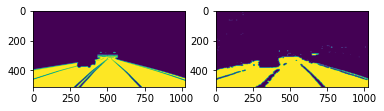

In [39]:
# Ground truth for road 
# Get road mask by choosing pixels in segmentation output with value 7
road_mask = np.zeros(mask_gound.shape)
road_mask[mask_gound == 7] = 1

# Show road mask
# plt.imshow(road_mask)

# Get x,y, and z coordinates of pixels in road mask
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = depth_img[road_mask == 1]
xyz_ground = np.stack((x_ground, y_ground, z_ground))

# Predicted road
# Get road mask by choosing pixels in segmentation output with value 7
road_mask_predicted = np.zeros(predicted_mask_resize.shape)
road_mask_predicted[predicted_mask_resize == 7] = 1

# Show road mask
# plt.imshow(road_mask_predicted)

# Get x,y, and z coordinates of pixels in road mask
x_ground_predicted = x[road_mask == 1]
y_ground_predicted = y[road_mask == 1]
z_ground_predicted = depth_img[road_mask == 1]
xyz_ground_predicted = np.stack((x_ground_predicted, y_ground_predicted, z_ground_predicted))

plotter(road_mask,road_mask_predicted)

In [34]:
def compute_plane(xyz):
    """
    Computes plane coefficients a,b,c,d of the plane in the form ax+by+cz+d = 0
    Arguments:
    xyz -- tensor of dimension (3, N), contains points needed to fit plane.
    k -- tensor of dimension (3x3), the intrinsic camera matrix
    Returns:
    p -- tensor of dimension (1, 4) containing the plane parameters a,b,c,d
    """
    ctr = xyz.mean(axis=1)
    normalized = xyz - ctr[:, np.newaxis]
    M = np.dot(normalized, normalized.T)

    p = np.linalg.svd(M)[0][:, -1]
    d = np.matmul(p, ctr)

    p = np.append(p, -d)

    # Correct plane
    # p = [0.0, 1.0, 0.0, -1.5]
    return p


def dist_to_plane(plane, x, y, z):
    """
    Computes distance between points provided by their x, and y, z coordinates
    and a plane in the form ax+by+cz+d = 0
    Arguments:
    plane -- tensor of dimension (4,1), containing the plane parameters [a,b,c,d]
    x -- tensor of dimension (Nx1), containing the x coordinates of the points
    y -- tensor of dimension (Nx1), containing the y coordinates of the points
    z -- tensor of dimension (Nx1), containing the z coordinates of the points
    Returns:
    distance -- tensor of dimension (N, 1) containing the distance between points and the plane
    """
    a, b, c, d = plane

    return (a * x + b * y + c * z + d) / np.sqrt(a**2 + b**2 + c**2)


def get_slope_intecept(lines):
    slopes = (lines[:, 3] - lines[:, 1]) / (lines[:, 2] - lines[:, 0] + 0.001)
    intercepts = ((lines[:, 3] + lines[:, 1]) - slopes * (
        lines[:, 2] + lines[:, 0])) / 2
    return slopes, intercepts


def extrapolate_lines(lines, y_min, y_max):
    slopes, intercepts = get_slope_intecept(lines)

    new_lines = []

    for slope, intercept, in zip(slopes, intercepts):
        x1 = (y_min - intercept) / slope
        x2 = (y_max - intercept) / slope
        new_lines.append([x1, y_min, x2, y_max])

    return np.array(new_lines)


def find_closest_lines(lines, point):
    x0, y0 = point
    distances = []
    for line in lines:
        x1, y1, x2, y2 = line
        distances.append(((x2 - x1) * (y1 - y0) - (x1 - x0) *
                          (y2 - y1)) / (np.sqrt((y2 - y1)**2 + (x2 - x1)**2)))

    distances = np.abs(np.array(distances))
    sorted = distances.argsort()

    return lines[sorted[0:2], :]

//TODO
1. Choose a minimum of 3 points from xyz_ground at random.

2. Compute the ground plane model using the chosen random points

3. Compute the distance from the ground plane model to every point in xyz_ground, and compute the number of inliers based on a distance threshold.

4. Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.

5. Repeat until number of iterations $\geq$ a preset number of iterations, or number of inliers $\geq$ minimum number of inliers.

6. Recompute and return a plane model using all inliers in the final inlier set.

In [35]:
def ransac_plane_fit(xyz_ground):
  # set threshold for ransac algorithm
  num_itr = 1000  # RANSAC maximum number of iterations
  min_num_inliers = 200000 # RANSAC minimum number of inliers
  distance_threshold = 0.00001  # Maximum distance from point to plane for point to be considered inlier
  N = xyz_ground.shape[1]
  inlineC_temp = []
  CCC_temp = np.zeros((3,4))
  for i in range(num_itr):
    # 1: choose a minimum of 3 points from xyz ground plane
    ac = np.random.choice(N,6)
    CCC = (np.vstack((xyz_ground.T[ac[0]],xyz_ground.T[ac[1]],xyz_ground.T[ac[2]],
                      xyz_ground.T[ac[3]],xyz_ground.T[ac[4]],xyz_ground.T[ac[5]]))).T
    # 2: compute plane model
    p = compute_plane(CCC)
    # 3: Find number of inliers
    bc = np.random.choice(N,150)
    xx=[]
    yy=[]
    zz=[]
       
    xx = np.array(xyz_ground[0,0:]).T
    yy = np.array(xyz_ground[1,0:]).T
    zz = np.array(xyz_ground[2,0:]).T
    dis = dist_to_plane(p,xx,yy,zz)
    # 4: Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.
    inlinec = np.zeros(dis.shape)
    inlinec[dis < distance_threshold] = 1
    # print(sum(inlinec))
    if sum(inlinec) > sum(inlineC_temp):
      CCC_temp = CCC

    # 5: Check if stopping criterion is satisfied and break.         
    if sum(inlinec) >= min_num_inliers:
      return p
        
  # 6: Recompute the model parameters using largest inlier set.
  p = compute_plane(CCC_temp)

  return p

In [36]:
p_final = ransac_plane_fit(xyz_ground_predicted)
print('Ground Plane: ' + str(p_final))

Ground Plane: [0.0054481  0.99232927 0.12350276 1.72208482]


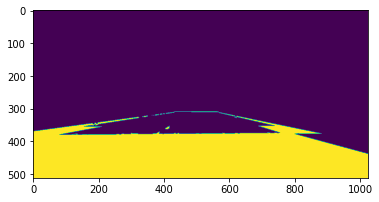

In [40]:
dist = np.abs(dist_to_plane(p_final, x, y, depth_img))

ground_mask_ = np.zeros(dist.shape)

ground_mask_[dist < 0.1] = 1
ground_mask_[dist > 0.1] = 0

plt.imshow(ground_mask_)

In [42]:
y_test = ground_mask
y_test_predict = ground_mask_
labels = [0,1,2,3,4,5,6, 7,8,9, 10,11,12]
target_names = ['None','Buildings','Fences','Other','Pedestrians','Poles','RoadLines',
                    'Roads','Sidewalks','Vegetation','Vehicles','Walls','Traffic signs']
classification_report(y_test, y_test_predict,
                              labels = labels,
                              target_names=target_names)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'               precision    recall  f1-score   support\n\n         None       1.00      1.00      1.00       143\n    Buildings       1.00      1.00      1.00       143\n       Fences       1.00      1.00      1.00       143\n        Other       1.00      1.00      1.00       143\n  Pedestrians       1.00      1.00      1.00       143\n        Poles       1.00      1.00      1.00       143\n    RoadLines       1.00      1.00      1.00       143\n        Roads       1.00      1.00      1.00       144\n    Sidewalks       1.00      1.00      1.00       144\n   Vegetation       1.00      1.00      1.00       144\n     Vehicles       1.00      1.00      1.00       144\n        Walls       1.00      1.00      1.00       144\nTraffic signs       1.00      1.00      1.00       144\n\n    micro avg       1.00      1.00      1.00      1865\n    macro avg       1.00      1.00      1.00      1865\n weighted avg       1.00      1.00      1.00      1865\n  samples avg       0.28      0.28      0.2